In [ ]:
from plot_utils import plot_coordination_histograms, plot_graph_structure, plot_cluster_size_distribution, plot_cluster_composition_analysis, plot_3d_cluster_visualization, plot_3d_cluster_with_graph, analyze_bond_network, plot_rdfs


In [43]:
from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier
import glob
import numpy as np
import re
from pathlib import Path

from tqdm.auto import tqdm

In [44]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import freud

In [45]:
from ase.io import read
from ase.io import write

In [46]:
atomba=read('/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.88/T900K/dump.lammpstrj',index='-501:-1')

In [47]:
at_list=set()
at_list.update(atomba[45].get_chemical_symbols())

In [48]:
at_list

{'Cl', 'Na', 'Pu'}

In [50]:
def coordination_per_atom_list_voronoi_freud2(atoms_list, at_list=None, min_area=0.0):


    # Build species universe
    if at_list is None:
        all_species = sorted({s for at in atoms_list for s in at.get_chemical_symbols()})
    else:
        all_species = list(at_list)
    sp2idx = {sp: i for i, sp in enumerate(all_species)}

    # Output structure: for each central species, a list of neighbor counts per neighbor species
    coord_data = {sp_c: {sp_n: [] for sp_n in all_species} for sp_c in all_species}

    for atoms in tqdm(atoms_list):
        assert atoms.pbc.all(), "freud Voronoi expects PBC in all directions."
        box = freud.box.Box.from_matrix(atoms.get_cell().array)
        pos = atoms.get_positions()
        species = np.array(atoms.get_chemical_symbols())
        species_idx = np.array([sp2idx[s] for s in species], dtype=int)

        v = freud.locality.Voronoi()
        v.compute((box, pos))

        # Neighbor list: i (central), j (neighbor), weight = facet area
        # The attributes below match common freud builds; if yours differs,
        # adjust to v.nlist[:,0], v.nlist[:,1], v.nlist.weights as in your code.
        i = v.nlist[:, 0]
        j = v.nlist[:, 1]
        areas = v.nlist.weights

        # Optional facet-area threshold
        mask = areas >= float(min_area)
        i = i[mask]
        j = j[mask]

        # Accumulate counts: rows=central atom index, cols=neighbor-species index
        N = len(atoms)
        S = len(all_species)
        counts = np.zeros((N, S), dtype=int)
        np.add.at(counts, (i, species_idx[j]), 1)

        # Split by central species and extend lists
        for sp_c, c_idx in sp2idx.items():
            rows = np.where(species_idx == c_idx)[0]
            if rows.size == 0:
                continue
            sub = counts[rows]  # shape: (#atoms of central species, S)
            for sp_n, n_idx in sp2idx.items():
                coord_data[sp_c][sp_n].extend(sub[:, n_idx].tolist())

        # print(counts)
        break

    return coord_data


In [51]:
#frued - voronoi idea
cordvorba_f2=coordination_per_atom_list_voronoi_freud2(atomba,at_list=at_list)

  0%|          | 0/500 [00:00<?, ?it/s]


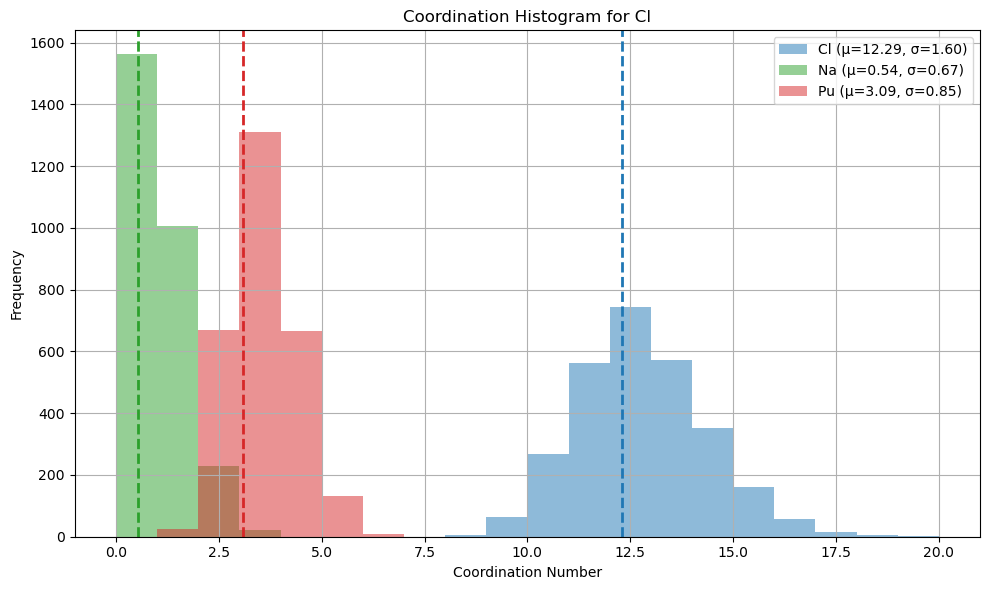

In [52]:
plot_coordination_histograms(cordvorba_f2,central_type='Cl')

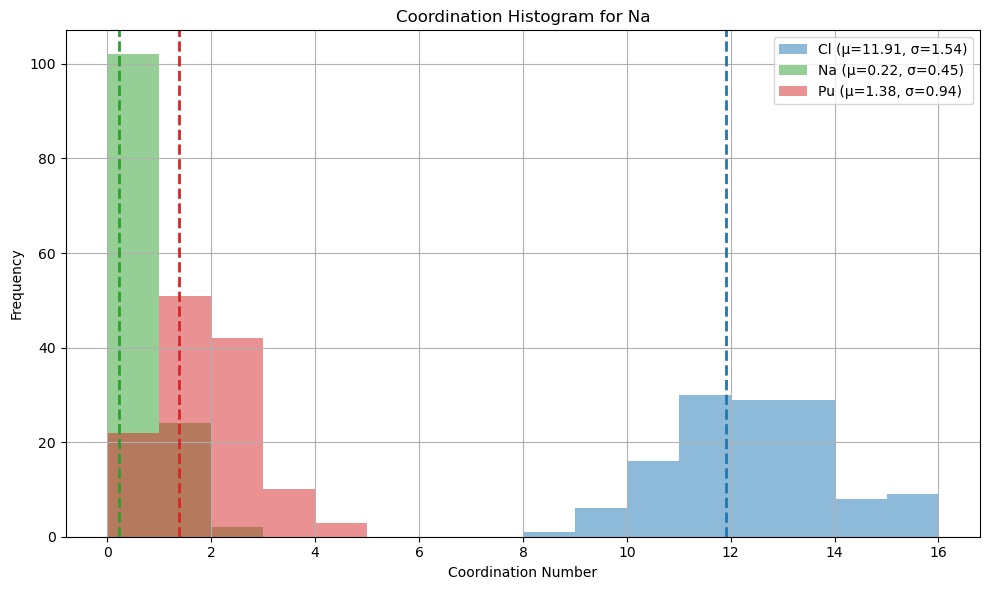

In [53]:
plot_coordination_histograms(cordvorba_f2,central_type='Na')

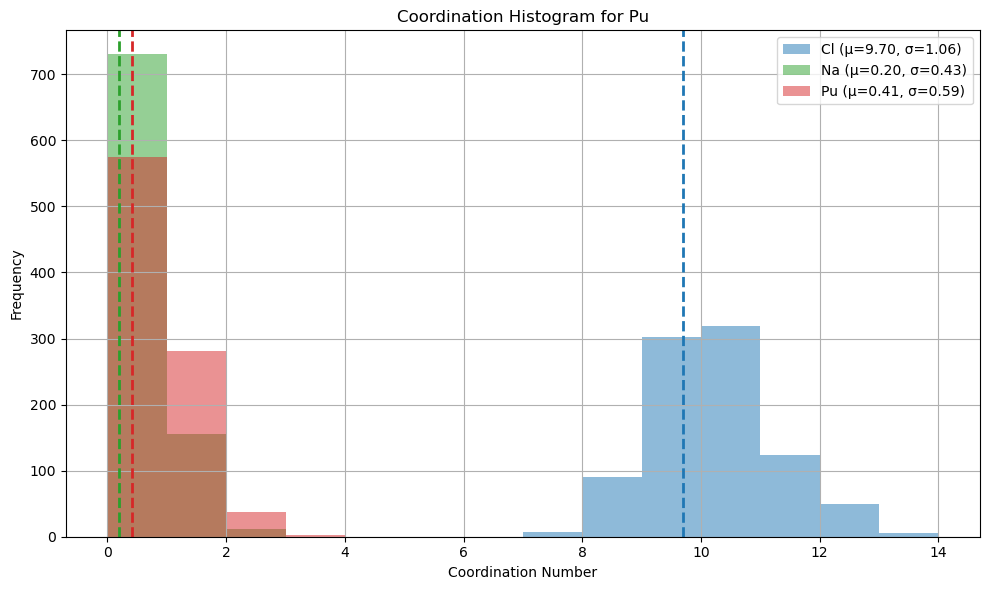

In [54]:
plot_coordination_histograms(cordvorba_f2,central_type='Pu')

In [55]:
def partial_rdf_first_min(atoms, pairs, r_max=8.0, bins=800):
    import numpy as np
    from scipy.signal import savgol_filter, argrelextrema
    import freud

    symbols = atoms.get_chemical_symbols()
    pos = atoms.get_positions()
    box = freud.box.Box.from_matrix(atoms.cell.array)

    a, b = pairs
    A_mask = np.array([s == a for s in symbols])
    B_mask = np.array([s == b for s in symbols])

    rdf = freud.density.RDF(bins=bins, r_max=r_max)
    rdf.compute((box, pos), query_points=pos[A_mask])  # centers = type A

    # freud doesn’t restrict neighbors by species → need to mask
    # so re-weight by restricting to B only:
    # easiest: recompute with both and then renormalize
    # or, use freud.locality.NeighborQuery instead (more control)

    r = rdf.bin_centers
    g = rdf.rdf

    # smooth & find first min
    gs = savgol_filter(g, 31, 3, mode='interp')
    peak = np.argmax(gs)
    minima = argrelextrema(gs, np.less)[0]
    r_min = r[minima[minima > peak][0]] if np.any(minima > peak) else None
    return r, g, r_min


In [56]:
r_pc, g_pc, rmin_pc = partial_rdf_first_min(atomba[0], ('Pu','Cl'))

In [57]:
import networkx as nx

In [58]:
def pu_connectivity_graph(atoms, rmin_pc):
    """
    Return NetworkX graph G over Pu sites.
    Nodes: Pu indices (in the frame)
    Edge weight: connectivity index Cn = # of shared Cl neighbors
    """
    sym = atoms.get_chemical_symbols()
    pos = atoms.get_positions()
    box = freud.box.Box.from_matrix(atoms.cell.array)

    pu_idx = np.array([i for i,s in enumerate(sym) if s=='Pu'], dtype=np.int32)
    cl_idx = np.array([i for i,s in enumerate(sym) if s=='Cl'], dtype=np.int32)

    # neighbor list Pu<-Cl within rmin_pc
    nlist = freud.locality.AABBQuery(box, pos[cl_idx]).query(pos[pu_idx], dict(r_max=rmin_pc)).toNeighborList()
    # map pu local index -> set of cl global indices
    pu_to_cls = defaultdict(set)
    for pu_local, cl_local, _ in zip(nlist.point_indices, nlist.query_point_indices, range(len(nlist.point_indices))):
        pu_global = pu_idx[cl_local]
        cl_global = cl_idx[pu_local]
        pu_to_cls[pu_global].add(cl_global)

    # build graph
    G = nx.Graph()
    G.add_nodes_from(pu_idx.tolist())

    pu_list = list(pu_to_cls.keys())
    # brute-force pairs inside this frame (Pu count is modest)
    for i_idx in range(len(pu_list)):
        i = pu_list[i_idx]
        for j in pu_list[i_idx+1:]:
            shared = pu_to_cls[i].intersection(pu_to_cls[j])
            Cn = len(shared)
            if Cn > 0:
                G.add_edge(i, j, weight=Cn)
    return G

def frame_cluster_stats(G):
    """
    Compute:
      - cluster size histogram
      - Pu-CN (degree) distribution
      - diameter vs size (for each connected component with >=2 nodes)
    """
    comps = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    sizes = [c.number_of_nodes() for c in comps]

    # degree per node (Pu-CN over the Pu network)
    degrees = [deg for _,deg in G.degree()]

    # diameter per component (only defined if connected & ≥2 nodes; for size==1, define 0)
    diameters = []
    for c in comps:
        if c.number_of_nodes() >= 2:
            # for weighted edges you could use weighted eccentricity; the paper uses topological steps
            diameters.append(nx.diameter(c))
        else:
            diameters.append(0)
    return np.array(sizes), np.array(degrees), np.array(diameters)


In [59]:
G=pu_connectivity_graph(atomba[0],rmin_pc)

In [63]:
a,b,c=frame_cluster_stats(G)

In [61]:
def aggregate_over_traj(traj, rmin_pc):
    all_sizes, all_degrees, all_diams = [], [], []
    for atoms in tqdm(traj):
        G = pu_connectivity_graph(atoms, rmin_pc)
        sizes, degrees, diams = frame_cluster_stats(G)
        all_sizes.extend(sizes)
        all_degrees.extend(degrees)
        all_diams.extend(diams)
    return np.array(all_sizes), np.array(all_degrees), np.array(all_diams)


In [64]:
a,b,c=aggregate_over_traj(atomba, rmin_pc)

100%|██████████| 500/500 [00:07<00:00, 62.79it/s]


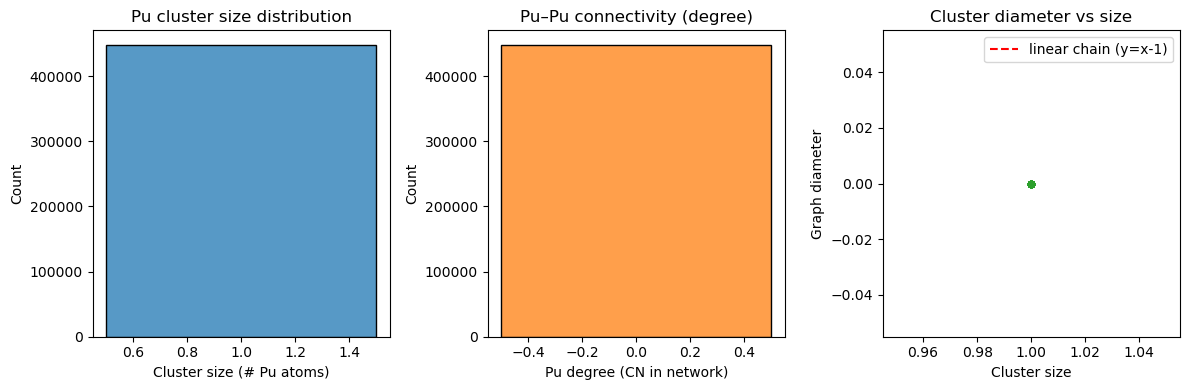

In [66]:
plot_cluster_stats(a,b,c)

In [67]:
a

array([1, 1, 1, ..., 1, 1, 1], shape=(448000,))

In [68]:
b

array([0, 0, 0, ..., 0, 0, 0], shape=(448000,))